## Working With Strings In Pandas 

In this mission, we'll learn a couple other string cleaning tasks such as:
- Finding specific strings or substrings in columns
- Extracting substrings from unstructured data
- Removing strings or substrings from a series

## Read the data 

In [1]:
import pandas as pd
happiness2015 = pd.read_csv("World_Happiness_2015.csv")
happiness2016 = pd.read_csv("World_Happiness_2016.csv")
happiness2017 = pd.read_csv("World_Happiness_2017.csv")

happiness2015['Year'] = 2015
happiness2016['Year'] = 2016
happiness2017['Year'] = 2017

In [4]:
print(happiness2015.head())

       Country          Region  Happiness Rank  Happiness Score  \
0  Switzerland  Western Europe               1            7.587   
1      Iceland  Western Europe               2            7.561   
2      Denmark  Western Europe               3            7.527   
3       Norway  Western Europe               4            7.522   
4       Canada   North America               5            7.427   

   Standard Error  Economy (GDP per Capita)   Family  \
0         0.03411                   1.39651  1.34951   
1         0.04884                   1.30232  1.40223   
2         0.03328                   1.32548  1.36058   
3         0.03880                   1.45900  1.33095   
4         0.03553                   1.32629  1.32261   

   Health (Life Expectancy)  Freedom  Trust (Government Corruption)  \
0                   0.94143  0.66557                        0.41978   
1                   0.94784  0.62877                        0.14145   
2                   0.87464  0.64938           

And this is the data after merged:

In [3]:
world_dev = pd.read_csv("World_dev.csv")
col_renaming = {'SourceOfMostRecentIncomeAndExpenditureData': 'IESurvey'}

merged = pd.merge(left=happiness2015, right=world_dev, how='left', left_on='Country', right_on='ShortName')
merged = merged.rename(col_renaming, axis=1)
print(merged)

         Country                         Region_x  Happiness Rank  \
0    Switzerland                   Western Europe               1   
1        Iceland                   Western Europe               2   
2        Denmark                   Western Europe               3   
3         Norway                   Western Europe               4   
4         Canada                    North America               5   
..           ...                              ...             ...   
153       Rwanda               Sub-Saharan Africa             154   
154        Benin               Sub-Saharan Africa             155   
155        Syria  Middle East and Northern Africa             156   
156      Burundi               Sub-Saharan Africa             157   
157         Togo               Sub-Saharan Africa             158   

     Happiness Score  Standard Error  Economy (GDP per Capita)   Family  \
0              7.587         0.03411                   1.39651  1.34951   
1              7.561 

## Using Apply to transform strings 

Let's work with the CurrencyUnit column first. Suppose we wanted to extract the unit of currency without the leading nationality. For example, instead of "Danish krone" or "Norwegian krone", we just needed "krone".
<br>
<br>
If we wanted to complete this task for just one of the strings, we could use Python's string.split() method:

In [5]:
words = 'Danish krone'

#Use the string.split() method to return the following list: ['Danish', 'krone']
listwords = words.split()

#Use the index -1 to return the last word of the list.
listwords[-1]

'krone'

Now, to repeat this task for each element in the Series, let's return to a concept we learned in the previous mission - the Series.apply() method.

In [6]:
def extract_last_word(element): 
    element = str(element).split()
    return element[-1]

merged['Currency Apply'] = merged['CurrencyUnit'].apply(extract_last_word)
merged['Currency Apply'].head(5)

0     franc
1     krona
2     krone
3     krone
4    dollar
Name: Currency Apply, dtype: object

## Vectorized String Methods 

The same function can be performed with the Series.str.split() method, the vectorized equivalent of Python's string.split() method. 

In [7]:
merged['Currency Vectorized'] = merged['CurrencyUnit'].str.split().str.get(-1)
merged['Currency Vectorized'].head()

0     franc
1     krona
2     krone
3     krone
4    dollar
Name: Currency Vectorized, dtype: object

One major difference between vectorized string methods and apply function is the treatment of NaN. 
<br>
<br>
First, let's use the Series.isnull() method to confirm if there are any missing values in the column:

In [8]:
merged['CurrencyUnit'].isnull().sum()

13

So, we know that the CurrencyUnit column has 13 missing values.Next, let's create a function to return the length of each currency unit and apply it to the CurrencyUnit column

In [9]:
def compute_lengths(element):
    return len(str(element))
lengths_apply = merged['CurrencyUnit'].apply(compute_lengths)

lengths_apply.value_counts(dropna=False)

14    21
4     20
12    17
13    14
3     13
15    13
16    12
18     9
17     9
11     8
22     7
25     5
19     3
9      2
26     1
20     1
23     1
10     1
39     1
Name: CurrencyUnit, dtype: int64

Since NaN is not included in the list of unique value, we know our function must have treated NaN as a string and returned a length of 3 for each NaN value. 
<br>
<br>
If we wanted to exclude missing values, we'd have to update our function to something like this:

In [10]:
def compute_lengths(element):
    if pd.isnull(element):
        pass
    else:
        return len(str(element))
lengths_apply = merged['CurrencyUnit'].apply(compute_lengths)

lengths_apply.value_counts(dropna=False)

14.0    21
4.0     20
12.0    17
13.0    14
NaN     13
15.0    13
16.0    12
18.0     9
17.0     9
11.0     8
22.0     7
25.0     5
19.0     3
9.0      2
10.0     1
39.0     1
26.0     1
23.0     1
20.0     1
Name: CurrencyUnit, dtype: int64

With vectorized string function, the NaN will be automatically identified

In [11]:
lengths = merged['CurrencyUnit'].str.len()
value_counts = lengths.value_counts(dropna=False)
value_counts

14.0    21
4.0     20
12.0    17
13.0    14
NaN     13
15.0    13
16.0    12
18.0     9
17.0     9
11.0     8
22.0     7
25.0     5
19.0     3
9.0      2
10.0     1
39.0     1
26.0     1
23.0     1
20.0     1
Name: CurrencyUnit, dtype: int64

## Finding Specific Words in Strings

One of the most common uses in vectorized string methods is data cleaning. 
<br>
<br>
Suppose we needed to parse the elements of a Series to find a string or substring that doesn't appear in the same position in each string.
<br>
<br>
For example, we would like to see how many rows in merged['SpecialNotes'] contain the string 'National accounts' or 'national accounts'. We can use the series.str.contains() together with regex to solve the problem

In [12]:
pattern = r"[Nn]ational accounts"
national_accounts = merged['SpecialNotes'].str.contains(pattern)
national_accounts.head()

0     NaN
1     NaN
2     NaN
3     NaN
4    True
Name: SpecialNotes, dtype: object

We used the Series.str.contains() method to see if a specific phrase appeared in a series. The result was a series containing True, False, and missing values. 
<br>
<br>
However, to be able to use boolean indexing to return only the rows that contain "national accounts" or "National accounts" in the SpecialNotes column, we need to simplify the output to only True/False. 
<br>
<br>What we can do is to switch the NaN value to false

In [13]:
pattern = r"[Nn]ational accounts"
national_accounts = merged['SpecialNotes'].str.contains(pattern, na=False)
merged_national_accounts = merged[national_accounts]
merged_national_accounts.head(5)

,Country,Region_x,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),...,LatestPopulationCensus,LatestHouseholdSurvey,IESurvey,VitalRegistrationComplete,LatestAgriculturalCensus,LatestIndustrialData,LatestTradeData,LatestWaterWithdrawalData,Currency Apply,Currency Vectorized
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,...,2011,NaN,"Labor force survey (LFS), 2010",Yes,2011,2011.0,2013.0,1986.0,dollar,dollar
7,Sweden,Western Europe,8,7.364,0.03157,1.33171,1.28907,0.91087,0.65980,0.43844,...,2011,NaN,"Income survey (IS), 2005",Yes,2010,2010.0,2013.0,2007.0,krona,krona
8,New Zealand,Australia and New Zealand,9,7.286,0.03371,1.25018,1.31967,0.90837,0.63938,0.42922,...,2013,NaN,NaN,Yes,2012,2010.0,2013.0,2002.0,dollar,dollar
9,Australia,Australia and New Zealand,10,7.284,0.04083,1.33358,1.30923,0.93156,0.65124,0.35637,...,2011,NaN,"Expenditure survey/budget survey (ES/BS), 2003",Yes,2011,2011.0,2013.0,2000.0,dollar,dollar
14,United States,North America,15,7.119,0.03839,1.39451,1.24711,0.86179,0.54604,0.15890,...,2010,NaN,"Labor force survey (LFS), 2010",Yes,2012,2008.0,2013.0,2005.0,dollar,dollar


## Extract substrings from a Series 

If we want to extract the matched string from a string, instead of only return true/false, we need to use the function extract

In [14]:
pattern =r"([1-2][0-9]{3})"
years = merged['SpecialNotes'].str.extract(pattern)
print(years.head(15))

       0
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5   1999
6   1999
7    NaN
8    NaN
9   1990
10  2010
11   NaN
12  1999
13  2008
14   NaN


In [15]:
pattern = r"([1-2][0-9]{3})"
years = merged['SpecialNotes'].str.extract(pattern, expand=True)
print(years.head(15))

       0
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5   1999
6   1999
7    NaN
8    NaN
9   1990
10  2010
11   NaN
12  1999
13  2008
14   NaN


## Extracting all matches of a pattern from a Series 

The Series.str.extract() method will only extract the first match of the pattern. If we wanted to extract all of the matches, we can use the Series.str.extractall() method.
<br>
<br>
In this case, if there are more than 1 times for each value, it will be counted for multiple times.

In [16]:
pattern = r"(?P<Years>[1-2][0-9]{3})"
years = merged['IESurvey'].str.extractall(pattern)
value_counts = years['Years'].value_counts()
print(value_counts)

2012    33
2010    28
2011    22
2013    12
2009     8
2008     6
2005     6
2007     4
2004     3
2006     1
1995     1
1998     1
1992     1
2000     1
2003     1
1999     1
2002     1
Name: Years, dtype: int64


## Extracting more than 1 group of a pattern from a Series

In [17]:
pattern = r"(?P<First_Year>[1-2][0-9]{3})/?(?P<Second_Year>[0-9]{2})?"
years = merged['IESurvey'].str.extractall(pattern)
first_two_year = years['First_Year'].str[0:2]
years['Second_Year'] = first_two_year + years['Second_Year']
print(years.head())

        First_Year Second_Year
  match                       
0 0           2004         NaN
1 0           2010         NaN
2 0           2010         NaN
3 0           2010         NaN
4 0           2010         NaN


## Clean a string column, aggregate the data, plot the results 

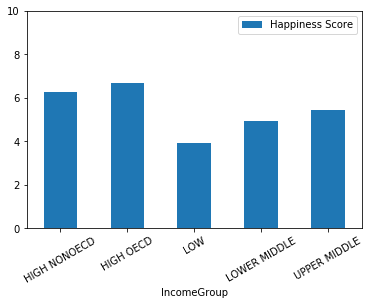

In [19]:
import matplotlib.pyplot as plt

merged['IncomeGroup'] = merged['IncomeGroup'].str.replace(' income', '').str.replace(':', '').str.upper()
pv_incomes = merged.pivot_table(values='Happiness Score', index='IncomeGroup')
pv_incomes.plot(kind='bar', rot=30, ylim=(0,10))
plt.show();